In [91]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import tqdm

In [92]:
path = os.path.dirname(os.getcwd())
data_path = os.path.join(path, 'data','web-Stanford.txt', 'web-Stanford.txt')
data_path

In [93]:
class edge_reservoir:
    def __init__(self,s_e):
        self.length=s_e
        self.mem=[set() for _ in range(self.length)]
    
    def add(self,edge,t,i):
        if random.random()<=1/t:
            self.mem[i]=edge
            return True
        return False
    

In [94]:
class wedge_reservoir:
    def __init__(self,s_w):
        self.length=s_w
        self.mem=[[frozenset(),frozenset()] for _ in range(self.length)]
        self.isClosed=[False for _ in range(self.length)]
    

In [95]:
def check_close(wedge:[frozenset,frozenset],edge:set):

    same=wedge[0]|wedge[1]
    return same!=None and (wedge[0]-set(same)).issubset(edge) and (wedge[1]-set(same)).issubset(edge)

In [96]:
tot_wedge=0

In [97]:
def update(edge,t,edge_res:edge_reservoir,wedge_res:wedge_reservoir):
    global tot_wedge
    for i in range(wedge_res.length):
        if check_close(wedge_res.mem[i],edge):
            wedge_res.isClosed[i]=True
    flag=False
    for i in range(min(edge_res.length,t)):
        if edge_res.add(edge,t,i):
            flag=True
    if flag:
        N_t=[]
        for ed in edge_res.mem:
            # print(ed,edge)
            if len(ed|edge)==1:
                tot_wedge+=1
                N_t.append([frozenset(ed),frozenset(edge)])
        for i in range(wedge_res.length):
            x=np.random.rand()
            if x<=len(N_t)/(tot_wedge+1e-8):
                w=random.choice(N_t)
                wedge_res.mem[i]=w
                wedge_res.isClosed[i]=False
    

In [98]:
def Streaming_triangles(filename,s_e,s_w):
    global tot_wedge
    edge_res=edge_reservoir(s_e)
    wedge_res=wedge_reservoir(s_w)
    T_t=[]
    with open(filename, 'r') as file:
        # Skip the header lines
        for _ in range(4):
            next(file)
        line_num=0
        
        for line in tqdm.tqdm(file):           
            if line.strip():
                line_num+=1
                edges=line.strip().split()
                edge={int(edges[0]),int(edges[1])}
                update(edge,line_num,edge_res,wedge_res)
                rol=sum(wedge_res.isClosed)/len(wedge_res.isClosed)
                T_t.append(rol*line_num**2/(s_e*(s_e-1))*tot_wedge)
                if tot_wedge!=0:
                    print(tot_wedge)
    plt.plot(T_t)




In [99]:
# Streaming_triangles(data_path,1000,1000)

In [100]:
def reservoir_sampling(filename, sample_size):
    reservoir = []
    with open(filename, 'r') as file:
        # Skip the header lines
        for _ in range(4):
            next(file)
        
        line_number = 0
        for line in file:
            line_number += 1
            if line.strip():  # Check if the line is not empty
                if len(reservoir) < sample_size:
                    reservoir.append(line.strip())
                else:
                    # Generate a random index from 0 to line_number (inclusive)
                    random_index = random.randint(0, line_number)
                    if random_index < sample_size:
                        reservoir[random_index] = line.strip()
    
    return reservoir



In [101]:
filename = data_path
sample_size = 10  # Set your desired sample size here
sample = reservoir_sampling(filename, sample_size)

# Print the sampled edges
print("Sampled edges:")
for edge in sample:
    print(edge)


Sampled edges:
123931	20634
77361	214128
40125	46540
38763	95363
223461	227439
39299	153049
230533	265127
30254	167295
139935	17567
81761	92605


In [102]:
from collections import defaultdict


In [132]:
class Triest_base:
    def __init__(self,M):
        assert M>=6
        self.length=M
        self.sample=[]
        self.t=0
        self.tau=0
        self.tauV=defaultdict(int)
        self.neighbours=defaultdict(set)
    
    def insert(self,filename):
        with open(filename, 'r') as file:
        # Skip the header lines
            for _ in range(4):
                next(file)
            
            for line in file:
                # if line.strip():
                    self.t+=1
                    edges=line.split()
                    edge=frozenset({int(edges[0]),int(edges[1])})
                    if self.sample_edge(edge):
                        self.sample.append(edge)
                        self.UpdateCounter(list(edge),"+")
        return self.tau*max(1,self.t*(self.t-1)*(self.t-2)/(self.length*(self.length-1)*(self.length-2)))

                    
    
    def sample_edge(self,edge:set):
        if self.t<=self.length:
            return True
        elif random.random()<=self.length/self.t:
            edge=random.choice(self.sample)
            self.sample.remove(edge)
            self.UpdateCounter(list(edge),"-")
            return True
        return False
    
    def UpdateCounter(self,edge,opeartion):
        u=edge[0]
        v=edge[1]
        if opeartion=="+":
            self.neighbours[u].add(v)
            self.neighbours[v].add(u)
            intersection=self.neighbours[u]&self.neighbours[v]
            for c in intersection:
                self.tau+=1
                self.tauV[c]+=1
                self.tauV[u]+=1
                self.tauV[v]+=1
        elif opeartion=="-":
            self.neighbours[u].discard(v)
            self.neighbours[v].discard(u)
            if len(self.neighbours[u])==0:
                del self.neighbours[u]
                return
            if len(self.neighbours[v])==0:
                del self.neighbours[v]
                return
            intersection=self.neighbours[u]&self.neighbours[v]
            for c in intersection:
                self.tau=max(0,self.tau-1)
                self.tauV[c]=max(0,self.tauV[c]-1)
                self.tauV[u]=max(0,self.tauV[u]-1)
                self.tauV[v]=max(0,self.tauV[v]-1) 



[500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]


100%|██████████| 10/10 [02:25<00:00, 14.60s/it]


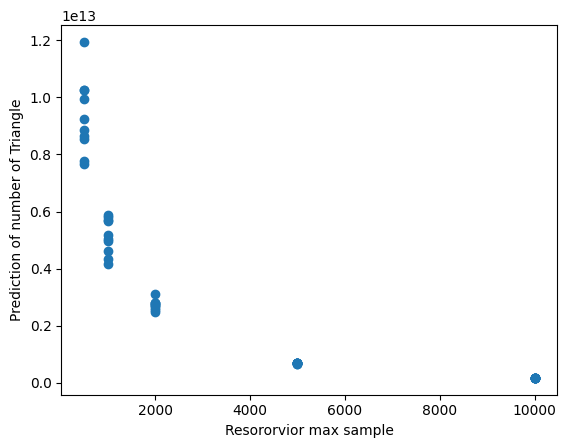

In [135]:
Ms=[500,1000,2000,5000,10000]
test=10
X=[i for i in Ms for _ in range(test)]
print(X)
Y=[]
for M in Ms:
    for _ in tqdm.tqdm(range(test)):
        algor=Triest_base(M=M)
        
        Y.append(algor.insert(data_path))
plt.scatter(X,Y)
plt.xlabel("Resororvior max sample")
plt.ylabel("Prediction of number of Triangle")
plt.show()


In [118]:
class TRIEST_IMPR:
    def __init__(self,M):
        self.length=M
        self.sample=list()
        self.t=-1
        self.tau=0
        self.tauV=defaultdict(int)
        self.neighbours=defaultdict(set)
    
    def insert(self,filename):
        with open(filename, 'r') as file:
        # Skip the header lines
            for _ in range(4):
                next(file)
            
            for line in file:
                if line.strip():
                    self.t+=1
                    edges=line.strip().split()
                    edge=frozenset({int(edges[0]),int(edges[1])})
                    self.UpdateCounter(list(edge))
                    if self.sample_edge(edge,self.t):
                        self.sample.append(edge)
                    
    
    def sample_edge(self,edge:set,t):
        if self.t<=self.length:
            return True
        elif random.random()<=self.length/t:
            edge=random.choice(self.sample)
            self.sample.remove(edge)
            return True
        return False
    
    def UpdateCounter(self,edge):
        u=edge[0]
        v=edge[1]
        self.neighbours[u].add(v)
        self.neighbours[v].add(u)
        intersection=self.neighbours[u]&self.neighbours[v]
        eta=max(1,(self.t-1)*(self.t-2)/(self.length*(self.length-1)))
        for c in intersection:
            self.tau+=eta
            self.tauV[c]+=eta
            self.tauV[u]+=eta
            self.tauV[v]+=eta


In [120]:
Ms=[1000,2000,5000,10000]
X=[1000]*10+[2000]*10+[5000]*10+[10000]*10
print(X)
Y=[]
for M in Ms:
    for _ in tqdm.tqdm(range(10)):
        algor=TRIEST_IMPR(M=M)
        algor.insert(data_path)
        Y.append(algor.tau)
plt.scatter(X,Y)
plt.xlabel("Resororvior max sample")
plt.ylabel("Prediction of number of Triangle")
plt.show()

[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]


 10%|█         | 1/10 [00:21<03:11, 21.24s/it]


KeyboardInterrupt: 